In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

height = 64
width = 64
image0 = np.zeros((height, width), dtype=np.uint8) 

def computehoughTransformCoord(x1, y1, x2, y2):

    if x1 == x2:
        return(np.pi/2, abs(y1-y2), abs(x1))

    k =  (y1 - y2) / (x1 - x2)
    theta = np.arctan(-k)

    A = y2 - y1
    B = x2 - x1
    C = abs(x2*y1 - x1*y2)
    length = np.sqrt(A**2 + B**2)
    rho = abs(C / length)
    
    return np.degrees(theta), length, rho

def simulateSigma(image0, noise_std, low, high, thetaT = 0, iterNum = 2000, draw = False):

    print(thetaT)
    height, width = image0.shape
    bound = int(width / 2)
    
    rhoT = 31.5 * np.sqrt(2) * np.sin(np.radians(thetaT - 45))
    rhoT = abs(rhoT)

    # for i in range(0, height):
    #     image0[i, 0: height-i] = low
    #     image0[i, height-i : height] = high
    
    # thetaT = 45
    # rhoT = height/np.sqrt(2)-0.5

    # image0[0:bound, :] = high
    # image0[bound:, :] = low

    f = lambda x, y: (x - width/2) * slope - (y - height/2) 

    slope = math.tan(math.radians(thetaT))  # 60度的斜率
    for x in range(width):
        for y in range(height):
            if f(x, y) > 0:
                image0[y, x] = low
            else:
                image0[y, x] = high

    lsd = cv2.createLineSegmentDetector(0)
    thetaList = []
    rhoList = []

    for iter in range(0, iterNum):
        image = image0 + np.round(np.random.normal(0, noise_std, image0.shape)).astype(int)
        image = np.uint8(image)

        if draw == True:
            cv2.imwrite("blur_image.png", image)

        lines, width, prec, nfa = lsd.detect(image)

        drawn_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        if lines is None:
            print("================empty lines==============")
        else:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                theta, length, rho = computehoughTransformCoord(x1, y1, x2, y2)

                if abs( rho - rhoT ) > 3 or abs(theta - thetaT) > 7:
                    # s=1
                    continue

                thetaList.append(theta)
                rhoList.append(rho)

                if draw == True:
                    x1, y1, x2, y2 = map(int, line[0])
                    drawn_img = cv2.line(drawn_img, (x1, y1), (x2, y2), (0, 255, 0), 1, cv2.LINE_AA)

                # print(f"theta : {theta}, rho : {rho}")
            if draw == True:
                cv2.imwrite(f"Draw/drawn_img{iter}.png", drawn_img)

    thetaList = np.asarray(thetaList)
    rhoList = np.asarray(rhoList)
    thetaSigma = np.std(thetaList)
    rhoSigma = np.std(rhoList)
    # print(np.mean(rhoList))
    # print(thetaSigma, rhoSigma)
    return thetaList, rhoList

In [69]:
high = 180
low = 70
noise = 20
thetaList, rhoList = simulateSigma(image0, noise, low, high, thetaT=0, iterNum=5000, draw=True)

0


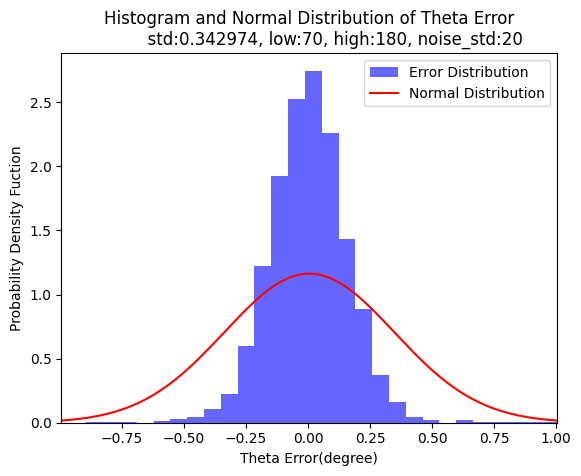

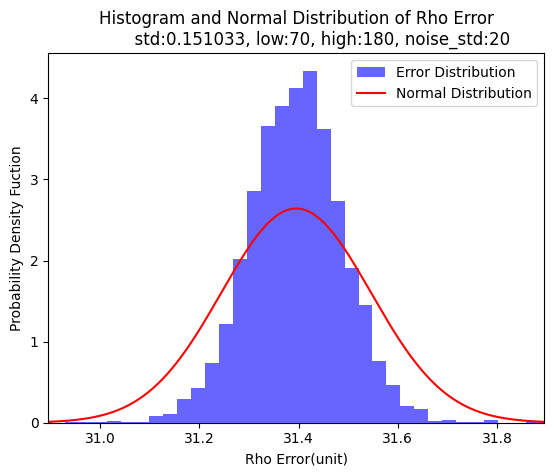

In [70]:
with open('output.txt', 'w') as file:
    for item in thetaList:
        file.write(str(item) + '\n')

# thetaList = np.sin(np.radians(thetaList))

# 计算thetaList的均值和方差
mean = np.mean(thetaList)
std_dev = np.std(thetaList)

mean_rho = np.mean(rhoList)
std_rho = np.std(rhoList)

d1 = 1
d2 = 0.5

# 生成正态分布曲线的x值
x = np.linspace(mean - d1, mean + d1, 1000)

# 生成正态分布曲线的y值
y = norm.pdf(x, mean, std_dev)

# 绘制直方图
plt.figure()
plt.hist(thetaList, bins=200, density=True, alpha=0.6, color='b', label='Error Distribution')

# 绘制正态分布曲线
plt.plot(x, y, 'r', label='Normal Distribution')
plt.xlabel('Theta Error(degree)')
plt.ylabel('Probability Density Fuction')
plt.title(f'Histogram and Normal Distribution of Theta Error\n\
          std:{std_dev:4f}, low:{low}, high:{high}, noise_std:{noise}')
plt.xlim(mean - d1, mean + d1)
plt.legend()
plt.show()

# 生成正态分布曲线的x值
x = np.linspace(mean_rho - d2, mean_rho + d2, 1000)

# 生成正态分布曲线的y值
y = norm.pdf(x, mean_rho, std_rho)

# 绘制直方图
plt.figure()
plt.hist(rhoList, bins=200, density=True, alpha=0.6, color='b', label='Error Distribution')

# 绘制正态分布曲线
plt.plot(x, y, 'r', label='Normal Distribution')
plt.xlabel('Rho Error(unit)')
plt.ylabel('Probability Density Fuction')
plt.title(f'Histogram and Normal Distribution of Rho Error\n\
          std:{std_rho:4f}, low:{low}, high:{high}, noise_std:{noise}')
plt.xlim(mean_rho - d2, mean_rho + d2)
plt.legend()
plt.show()